# 资讯分析师

## 准备工作

pip安装 `akshare` 和 `langchain` 等必需的库：

In [1]:
%pip install --upgrade --quiet pandas akshare lark langchain-core langchain-openai langchain-community langchain-chroma langgraph

Note: you may need to restart the kernel to use updated packages.


获取股票主营介绍数据：

In [ ]:
import pandas as pd
import akshare as ak

# 沪深京 A 股实时行情数据
stock_zh_a_spot_em_df = ak.stock_zh_a_spot_em()
# 股票对应的主营介绍数据
stock_zyjs_ths_dfs = []
for stock_code, stock_name in zip(stock_zh_a_spot_em_df['代码'], stock_zh_a_spot_em_df['名称']):
    try:
        stock_zyjs_ths_df = ak.stock_zyjs_ths(stock_code)
        stock_zyjs_ths_df['股票名称'] = stock_name
        stock_zyjs_ths_dfs.append(stock_zyjs_ths_df)
    except Exception as e:
        print(f'Error processing stock {stock_code}: {e}')
        continue
stock_zyjs_ths_df = pd.concat(stock_zyjs_ths_dfs)
stock_zyjs_ths_df.to_csv('data/stock_zyjs_ths.csv', index=False, quoting=1)

加载股票主营介绍数据：

In [5]:
from langchain_community.document_loaders.csv_loader import CSVLoader

loader = CSVLoader(
    file_path='data/stock_zyjs_ths.csv',
    csv_args={
        'delimiter': ',',
        'quotechar': '"',
    },
    metadata_columns=['股票代码', '股票名称']
)

documents = loader.load()
print(f'Loaded {len(documents)} documents')

Loaded 5662 documents


embedding股票主营介绍数据并存储到向量数据库：

In [ ]:
import os
import pandas as pd

from langchain_openai import AzureOpenAIEmbeddings
from langchain_chroma import Chroma

embeddings = AzureOpenAIEmbeddings(
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME'],
    openai_api_version=os.environ['AZURE_OPENAI_EMBEDDING_API_VERSION'],
)

vector_store = Chroma(
    collection_name='stock_zyjs_ths',
    embedding_function=embeddings,
    persist_directory='data/verctor_store.db',
)

ids = pd.read_csv('data/stock_zyjs_ths.csv')['股票代码'].astype(str).tolist()

for i in range(0, len(ids), 100):
    print(f'Adding documents {i} to {i+100}')
    partial_ids = ids[i:i+100]
    partial_documents = documents[i:i+100]
    # vector_store.add_documents(documents=partial_documents, ids=partial_ids)
    vector_store.update_documents(documents=partial_documents, ids=partial_ids)

## 资讯分析

初始化LLM模型和向量数据库：

In [1]:
import os

from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from langchain_openai.chat_models.base import BaseChatOpenAI
from langchain_chroma import Chroma

# llm = AzureChatOpenAI(
#     azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
#     azure_deployment=os.environ['AZURE_OPENAI_CHAT_DEPLOYMENT_NAME'],
#     openai_api_version=os.environ['AZURE_OPENAI_CHAT_API_VERSION'],
# )

llm = BaseChatOpenAI(
    model='deepseek-chat', 
    openai_api_base=os.environ['DEEPSEEK_ENDPOINT'],
    openai_api_key=os.environ['DEEPSEEK_API_KEY'], 
    max_tokens=1024
)


embeddings = AzureOpenAIEmbeddings(
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME'],
    openai_api_version=os.environ['AZURE_OPENAI_EMBEDDING_API_VERSION'],
)

vector_store = Chroma(
    collection_name='stock_zyjs_ths',
    embedding_function=embeddings,
    persist_directory='data/verctor_store.db',
)

定义状态：

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langgraph.graph.message import add_messages

class State(TypedDict):
    news: str
    category: str
    messages: Annotated[list, add_messages]
    stocks: list[Document]
    report: str

定义获取财经新闻工具：

In [3]:
import akshare as ak

def get_financial_news(state: State):
    """Call the AkShare API to get the latest financial news."""
    stock_info_global_sina_df = ak.stock_info_global_sina()
    first_stock_info = stock_info_global_sina_df.iloc[0]['内容']
    return {
        'news': first_stock_info
    }


定义新闻分类节点:

In [4]:
from langchain_core.prompts import PromptTemplate

news_category_prompt_template = PromptTemplate.from_template('''你是一个财经新闻分类助手。
请根据以下财经新闻的内容，将其分类到适当的类别中。可用的类别包括：
1. 公司新闻
2. 行业动态
3. 市场趋势
4. 经济指标
5. 政策法规
如果无法确定分类，请输出“无法确定”。
以下是需要分类的财经新闻：
{news}
''')

get_news_category_chain = news_category_prompt_template | llm
def get_news_category(state: State):
    message = get_news_category_chain.invoke(state)
    return {
        'category': message.content
    }

定义公司新闻分析节点：

In [5]:
from langchain_core.prompts import PromptTemplate

company_news_analysis_prompt_template = PromptTemplate.from_template('''你是一个公司新闻分析助手。
请根据以下公司新闻的内容，分析其对公司的影响。从以下几个方面进行分析：
1. 公司业务
2. 公司财务
3. 公司管理
4. 公司风险
5. 公司前景
以下是需要分析的公司新闻：
{news}
''')

get_company_news_analysis_chain = company_news_analysis_prompt_template | llm
def get_company_news_analysis(state: State):
    message = get_company_news_analysis_chain.invoke(state)
    return {
        'messages': [message]
    }

定义行业动态新闻分析节点：

In [6]:
from langchain_core.prompts import PromptTemplate

industry_news_analysis_prompt_template = PromptTemplate.from_template('''你是一个行业新闻分析助手。
请根据以下行业新闻的内容，分析其对行业的影响。从以下几个方面进行分析：
1. 行业发展
2. 行业竞争
3. 行业政策
4. 行业前景
以下是需要分析的行业新闻：
{news}
''')

get_industry_news_analysis_chain = industry_news_analysis_prompt_template | llm
def get_industry_news_analysis(state: State):
    message = get_industry_news_analysis_chain.invoke(state)
    return {
        'messages': [message]
    }

定义市场趋势新闻分析节点：

In [7]:
from langchain_core.prompts import PromptTemplate

market_news_analysis_prompt_template = PromptTemplate.from_template('''你是一个市场新闻分析助手。
请根据以下市场新闻的内容，分析其对市场的影响。从以下几个方面进行分析：
1. 市场趋势
2. 市场风险
3. 市场前景
以下是需要分析的市场新闻：
{news}
''')

get_market_news_analysis_chain = market_news_analysis_prompt_template | llm
def get_market_news_analysis(state: State):
    message = get_market_news_analysis_chain.invoke(state)
    return {
        'messages': [message]
    }

定义经济指标新闻分析节点：

In [8]:
from langchain_core.prompts import PromptTemplate

metrics_news_analysis_prompt_template = PromptTemplate.from_template('''你是一个经济指标分析助手。
请根据以下经济指标的内容，分析其对经济的影响。从以下几个方面进行分析：
1. 经济增长
2. 通货膨胀
3. 就业情况
4. 利率水平
5. 汇率变动
以下是需要分析的经济指标新闻：
{news}
''')

get_metrics_news_analysis_chain = metrics_news_analysis_prompt_template | llm
def get_metrics_news_analysis(state: State):
    message = get_metrics_news_analysis_chain.invoke(state)
    return {
        'messages': [message]
    }

定义政策法规新闻分析节点：

In [9]:
from langchain_core.prompts import PromptTemplate

policy_news_analysis_prompt_template = PromptTemplate.from_template('''你是一个政策新闻分析助手。
请根据以下政策新闻的内容，分析其对政策的影响。从以下几个方面进行分析：
1. 政策内容
2. 政策目的
3. 政策影响
以下是需要分析的政策新闻：
{news}
''')

get_policy_news_analysis_chain = policy_news_analysis_prompt_template | llm
def get_policy_news_analysis(state: State):
    message = get_policy_news_analysis_chain.invoke(state)
    return {
        'messages': [message]
    }

定义无法确定分类的新闻节点：

In [10]:
from langchain_core.messages import AIMessage

def get_unknown_category_analysis(state: State):
    return {
        'messages': [AIMessage(content='暂无分析')]
    }

定义检索器节点：

In [11]:
from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name='股票代码',
        description='股票代码',
        type='string',
    ),
    AttributeInfo(
        name='股票名称',
        description='股票名称',
        type='integer',
    ),
]

document_content_description = '股票主营介绍'

retriever = SelfQueryRetriever.from_llm(
    llm,
    vector_store,
    document_content_description,
    metadata_field_info,
)

def search_stocks(state: State):
    messages = state['messages']
    stocks = retriever.invoke(messages[-1].content)
    return {
        'stocks': stocks
    }

定义输出报告节点：

In [12]:
def get_report(state: State):
    news = state['news']
    messages = state['messages']
    report = f'''最新财经新闻：{news}
分类结果：{state['category']}
报告：{messages[-1].content}
可能受到影响的股票：{', '.join([stock.metadata['股票名称'] for stock in state['stocks']])}
'''
    return {
        'report': report
    }

定义并编译图：

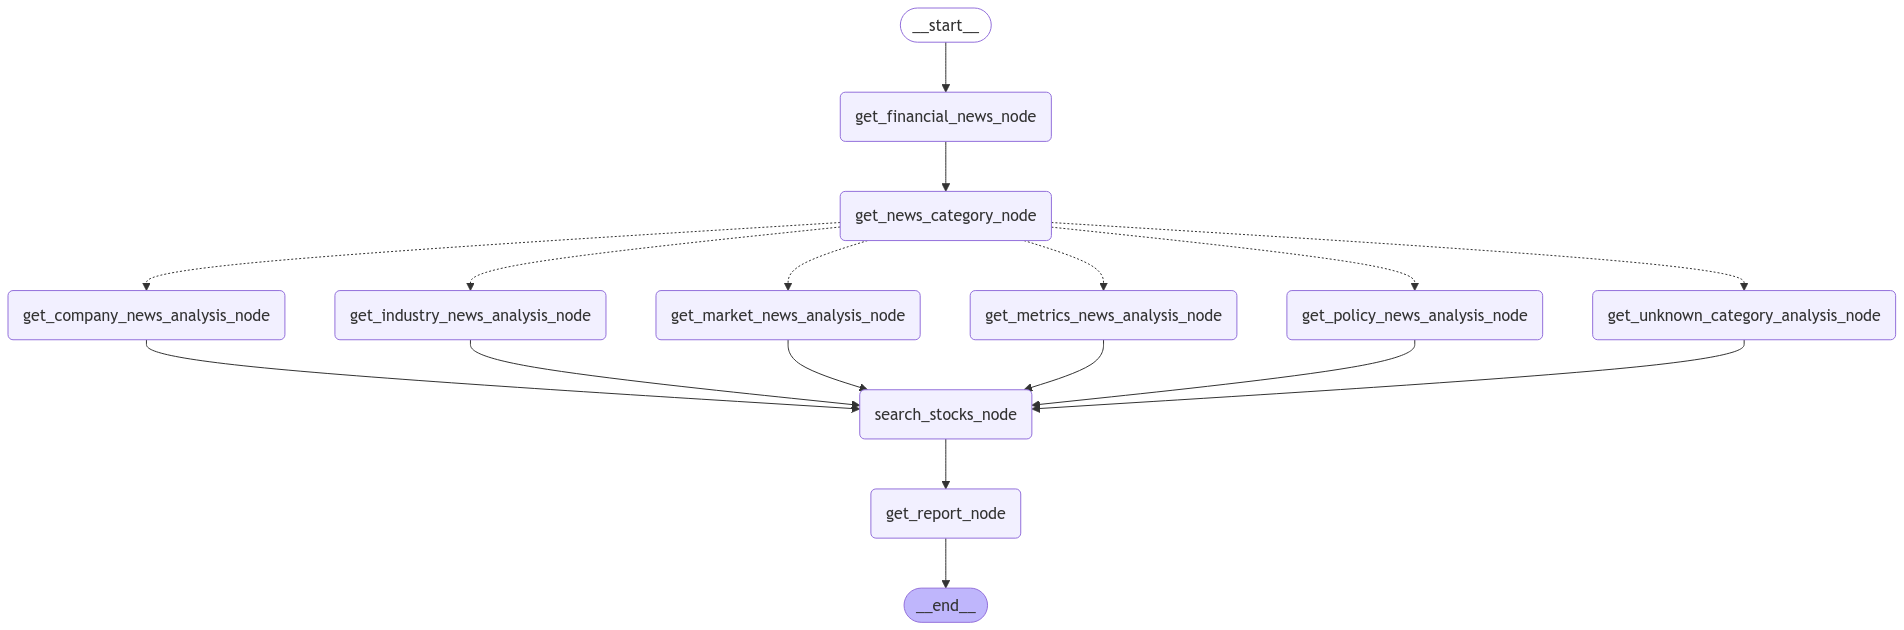

In [13]:
from langchain_core.globals import set_llm_cache
from langchain_core.caches import InMemoryCache
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from IPython.display import Image, display

set_llm_cache(InMemoryCache())

workflow = StateGraph(State)
news_category_nodes = ['get_company_news_analysis_node', 'get_industry_news_analysis_node', 'get_market_news_analysis_node', 'get_metrics_news_analysis_node', 'get_policy_news_analysis_node', 'get_unknown_category_analysis_node']
news_category_functions = [get_company_news_analysis, get_industry_news_analysis, get_market_news_analysis, get_metrics_news_analysis, get_policy_news_analysis, get_unknown_category_analysis]
workflow.add_node('get_financial_news_node', get_financial_news)
workflow.add_node('get_news_category_node', get_news_category)
for news_category_node, news_category_function in zip(news_category_nodes, news_category_functions):
    workflow.add_node(news_category_node, news_category_function)
workflow.add_node('search_stocks_node', search_stocks)
workflow.add_node('get_report_node', get_report)

def route_news_category(state: State):
    category = state['category']
    if '公司新闻' in category:
        return ['get_company_news_analysis_node']
    elif '行业动态' in category:
        return ['get_industry_news_analysis_node']
    elif '市场趋势' in category:
        return ['get_market_news_analysis_node']
    elif '经济指标' in category:
        return ['get_metrics_news_analysis_node']
    elif '政策法规' in category:
        return ['get_policy_news_analysis_node']
    else:
        return ['get_unknown_category_analysis_node']

workflow.add_edge(START, 'get_financial_news_node')
workflow.add_edge('get_financial_news_node', 'get_news_category_node')
workflow.add_conditional_edges('get_news_category_node', route_news_category, news_category_nodes)
for news_category_node in news_category_nodes:
    workflow.add_edge(news_category_node, 'search_stocks_node')
workflow.add_edge('search_stocks_node', 'get_report_node')
workflow.add_edge('get_report_node', END)

checkpointer = MemorySaver()

app = workflow.compile(checkpointer=checkpointer)

display(Image(app.get_graph().draw_mermaid_png()))


执行图：

In [14]:
final_state = app.invoke(
    {'news': None, 'messages': [], 'stocks': [], 'report': None},
    config={'configurable': {'thread_id': 'information_analysis'}},
)

print(final_state['report'])

最新财经新闻：【李强同外国专家举行新春座谈会 丁薛祥出席】在农历新春佳节即将到来之际，国务院总理李强1月26日下午在人民大会堂与获得2024年度中国政府友谊奖和在华工作的外国专家代表座谈交流。李强指出，过去一年，中国发展取得了新的成绩，外国专家为此作出积极贡献。大家在华工作、生活的经历，也是中国与世界良性互动、深度融合的生动缩影。从中可以得到许多重要的启示，突出的有两点：一是世界需要交流。当今世界并不安宁，国际环境越复杂，越需要各国敞开胸怀、沟通对话。这些年，随着大数据、物联网、人工智能等技术迅猛发展，各国人员往来、信息交互越来越便捷频繁，全球化进程不可逆转。中国一贯主张加强国际沟通对话，鼓励开展中外各层级、各方面交流往来，推动互学互鉴，促进民心相通。我们将继续坚持开放包容，积极促进各领域国际交流，推动各方通过坦诚对话、友好协商，化解矛盾分歧，共促和平发展。二是创新需要合作。随着新一轮科技革命和产业变革深入发展，科学研究的复杂性、系统性显著增强，开放合作是大势所趋和必然选择。这些年，中国以实际行动促进科技合作和成果共享，主动融入全球创新网络，发起国际科技合作倡议，支持各国科研人员共同探讨科技发展前沿问题。我们将继续扩大科技开放，拓展和深化联合科研，深度参与全球科技治理，同各国一道合作解决实际问题，携手应对全球挑战。（新华社）
分类结果：无法确定

解释：该新闻主要报道了国务院总理李强与外国专家代表座谈交流的内容，涉及国际合作、科技创新等话题，但并未明确聚焦于公司、行业、市场趋势、经济指标或政策法规等具体财经类别。因此，无法将其准确归类到提供的财经新闻类别中。
报告：1. **市场趋势**：  
   新闻中提到中国将继续坚持开放包容，促进国际交流与合作，特别是在科技创新领域。这表明中国将进一步融入全球创新网络，推动科技合作和成果共享。这一趋势将有助于中国在高科技领域（如人工智能、物联网、大数据等）的进一步发展，并可能带动相关行业的增长。同时，全球化进程的不可逆转性也意味着中国企业将继续在国际市场上扩展业务，推动跨境投资和贸易的增长。

2. **市场风险**：  
   尽管中国强调开放合作，但国际环境的不确定性仍然存在。全球政治经济形势复杂多变，地缘政治风险、贸易摩擦、技术封锁等因素可能对中国的国际合作和科技发展构成挑战。此外，随着中国在科技领域的快速崛起，部分国